# QECToStim · End-to-End Fault-Tolerance Scaling

Interactive notebook version of `tests/test_end_to_end_scaling.py`.

**Three phases:**
1. **Determinism** — Every circuit is fully deterministic at $p = 0$ (zero detector flips)
2. **Decoder × Gadget matrix** — All supported (code, gadget, basis) combos produce $0 < \text{LER} < 0.50$ at a moderate noise rate
3. **Noise scaling** — $\text{LER}(p) \approx C \cdot p^\alpha$ with $\alpha \approx (d+1)/2$

**Decoder:** `ConcatMLEDecoder` (auto-selects tesseract → bposd → exact MLE)

**DEM sampler:** `stim.CompiledDemSampler` — returns `(det_samples, obs_samples, err_samples)` tuple

In [15]:
# ── Imports & path setup ─────────────────────────────────────────────
import sys, os, time
import numpy as np
from dataclasses import dataclass
from typing import Optional, List, Tuple

# Ensure src/ is on sys.path
_repo_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if os.path.basename(os.getcwd()) != 'notebooks':
    _repo_root = os.getcwd()
_src_dir = os.path.join(_repo_root, 'src')
if _src_dir not in sys.path:
    sys.path.insert(0, _src_dir)

import stim
import matplotlib.pyplot as plt
import matplotlib

# QECToStim imports
from qectostim.experiments.ft_gadget_experiment import (
    FaultTolerantGadgetExperiment,
    validate_circuit_detectors,
)
from qectostim.codes.surface.rotated_surface import RotatedSurfaceCode
from qectostim.codes.small.steane_713 import SteaneCode713
from qectostim.codes.small.shor_code import ShorCode91
from qectostim.codes.abstract_code import Code

from qectostim.gadgets.transversal_cnot import TransversalCNOTGadget
from qectostim.gadgets.teleportation_h_gadgets import (
    CZHTeleportGadget,
    CNOTHTeleportGadget,
)
from qectostim.gadgets.base import Gadget
from qectostim.noise.models import CircuitDepolarizingNoise
from qectostim.decoders.concat_mle_decoder import ConcatMLEDecoder
from qectostim.decoders.decoder_selector import select_decoder

# Plotting style
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'font.size': 12,
    'axes.grid': True,
    'grid.alpha': 0.3,
})

print(f'stim {stim.__version__}')
print(f'numpy {np.__version__}')
print(f'matplotlib {matplotlib.__version__}')
print('\nAll imports OK \u2713')

stim 1.15.0
numpy 2.2.6
matplotlib 3.10.7

All imports OK ✓


## Configuration

Tune these to trade speed vs. statistical precision.

In [9]:
# ── Tunable parameters ───────────────────────────────────────────────
MATRIX_P     = 3e-3    # physical error rate for Phase 2 matrix
MATRIX_SHOTS = 500     # shots per (code, gadget, basis) combo

ALPHA_P_LO   = 2e-3    # lower p for noise-scaling fit
ALPHA_P_HI   = 5e-3    # upper p for noise-scaling fit
ALPHA_SHOTS  = 2000    # shots per alpha data point (need enough for nonzero LER at p_lo)
ALPHA_TOL    = 1.0     # acceptable |alpha_measured - alpha_expected|

# For the multi-point scaling plot (Phase 4)
PLOT_P_VALUES = [1e-3, 2e-3, 3e-3, 5e-3, 8e-3]
PLOT_SHOTS    = 500    # shots per p-value for the plot

print('Configuration loaded ✓')

Configuration loaded ✓


## Helper Functions & Data Structures

In [3]:
# ── Data structures ──────────────────────────────────────────────────

@dataclass
class LERResult:
    """One logical error rate measurement."""
    code_name: str
    distance: int
    gadget_name: str
    decoder_backend: str
    physical_p: float
    logical_error_rate: float
    num_shots: int
    num_errors: int
    num_detectors: int
    num_observables: int
    num_rounds_before: int
    num_rounds_after: int
    measurement_basis: str
    wall_seconds: float


def _is_self_dual(code: Code) -> bool:
    if not hasattr(code, 'hx') or not hasattr(code, 'hz'):
        return False
    return np.array_equal(code.hx, code.hz)


def _code_distance(code: Code) -> int:
    if hasattr(code, 'distance'):
        d = code.distance
        if isinstance(d, int) and d >= 1:
            return d
    return 3


# ── Core build & measure functions ────────────────────────────────────

def _build_experiment(code, gadget, num_blocks, p,
                      num_rounds_before=None, num_rounds_after=None):
    """Build a FaultTolerantGadgetExperiment with TQEC conventions."""
    d = _code_distance(code)
    if num_rounds_before is None:
        num_rounds_before = d + 1 if isinstance(gadget, CNOTHTeleportGadget) else d
    if num_rounds_after is None:
        num_rounds_after = d
    noise = CircuitDepolarizingNoise(p1=p, p2=p) if p > 0 else None
    return FaultTolerantGadgetExperiment(
        codes=[code] * num_blocks,
        gadget=gadget,
        noise_model=noise,
        num_rounds_before=num_rounds_before,
        num_rounds_after=num_rounds_after,
    )


def _build_dem(circuit):
    """Build DEM with graceful decomposition fallback."""
    for strategy in ['decompose', 'ignore_failures', 'no_decompose']:
        try:
            if strategy == 'decompose':
                return circuit.detector_error_model(decompose_errors=True)
            elif strategy == 'ignore_failures':
                return circuit.detector_error_model(
                    decompose_errors=True,
                    ignore_decomposition_failures=True,
                )
            else:
                return circuit.detector_error_model(decompose_errors=False)
        except Exception:
            continue
    raise RuntimeError('Cannot build DEM with any strategy')


def _measure_ler(code, gadget, num_blocks, p, shots,
                 num_rounds_before=None, num_rounds_after=None):
    """Measure LER using ConcatMLEDecoder + DEM sampler."""
    exp = _build_experiment(code, gadget, num_blocks, p,
                           num_rounds_before, num_rounds_after)
    circuit = exp.to_stim()
    dem = _build_dem(circuit)
    decoder = ConcatMLEDecoder(dem=dem)
    sampler = dem.compile_sampler()

    t0 = time.time()
    det_samples, obs_samples, _ = sampler.sample(shots=shots)
    corrections = decoder.decode_batch(det_samples)
    predicted_obs = corrections % 2
    actual_obs = obs_samples.astype(np.uint8)
    errors = np.any(predicted_obs != actual_obs, axis=1)
    num_errors = int(errors.sum())
    ler = num_errors / shots
    dt = time.time() - t0

    d = _code_distance(code)
    code_name = getattr(code, 'name', None) or type(code).__name__
    return LERResult(
        code_name=code_name, distance=d,
        gadget_name=type(gadget).__name__,
        decoder_backend=decoder.active_backend,
        physical_p=p, logical_error_rate=ler,
        num_shots=shots, num_errors=num_errors,
        num_detectors=circuit.num_detectors,
        num_observables=circuit.num_observables,
        num_rounds_before=exp.num_rounds_before,
        num_rounds_after=exp.num_rounds_after,
        measurement_basis=gadget.get_measurement_basis(),
        wall_seconds=dt,
    )


print('Helper functions defined \u2713')

Helper functions defined ✓


---
## Phase 1: Zero-Noise Determinism

Every circuit must be fully deterministic at $p = 0$: **zero detector flips** in a noiseless sample.

This validates stabilizer tracking, crossing detectors, boundary detectors, anchor detectors, and the observable.

In [4]:
# ── Phase 1: Determinism checks ──────────────────────────────────────

codes = [
    ('Steane [[7,1,3]]', SteaneCode713(),       3),
    ('Shor [[9,1,3]]',   ShorCode91(),          3),
    ('RotSurf d=3',      RotatedSurfaceCode(3), 3),
    ('RotSurf d=5',      RotatedSurfaceCode(5), 5),
]

gadget_defs = [
    ('TransversalCNOT',      lambda d, s: TransversalCNOTGadget(),                             2, False, ['Z']),
    ('CZ H-Teleportation',   lambda d, s: CZHTeleportGadget(num_ec_rounds=d, input_state=s),   1, True,  ['Z', 'X']),
    ('CNOT H-Teleportation', lambda d, s: CNOTHTeleportGadget(num_ec_rounds=d, input_state=s), 1, False, ['Z', 'X']),
]

known_skip = {('Shor [[9,1,3]]', 'CNOT H-Teleportation')}

det_rows = []
for code_name, code, dist in codes:
    for gadget_name, gadget_fn, num_blocks, needs_self_dual, bases in gadget_defs:
        for basis in bases:
            label = f'{code_name} + {gadget_name} M{basis}'

            # Skip conditions
            if needs_self_dual and not _is_self_dual(code):
                det_rows.append(dict(
                    Code=code_name, Gadget=gadget_name, Basis=f'M{basis}',
                    Status='\u23ed SKIP', Detectors='\u2014', Rounds='\u2014',
                    Time='\u2014', Reason='requires self-dual'))
                continue
            if (code_name, gadget_name) in known_skip:
                det_rows.append(dict(
                    Code=code_name, Gadget=gadget_name, Basis=f'M{basis}',
                    Status='\u23ed SKIP', Detectors='\u2014', Rounds='\u2014',
                    Time='\u2014', Reason='known crossing gap'))
                continue

            t0 = time.time()
            try:
                input_state = '+' if basis == 'X' else '0'
                gadget = gadget_fn(dist, input_state)
                exp = _build_experiment(code, gadget, num_blocks, p=0.0)
                circuit = exp.to_stim()
                ok, err = validate_circuit_detectors(circuit)
                if not ok:
                    det_rows.append(dict(
                        Code=code_name, Gadget=gadget_name, Basis=f'M{basis}',
                        Status='\u2717 FAIL', Detectors=str(circuit.num_detectors),
                        Rounds=f'{exp.num_rounds_before}+{exp.num_rounds_after}',
                        Time=f'{time.time()-t0:.1f}s', Reason=err[:50]))
                    continue
                det_vals = circuit.compile_detector_sampler().sample(1)[0]
                n_flips = int(sum(det_vals))
                dt = time.time() - t0
                det_rows.append(dict(
                    Code=code_name, Gadget=gadget_name, Basis=f'M{basis}',
                    Status='\u2713 PASS' if n_flips == 0 else f'\u2717 {n_flips} flips',
                    Detectors=str(circuit.num_detectors),
                    Rounds=f'{exp.num_rounds_before}+{exp.num_rounds_after}',
                    Time=f'{dt:.1f}s', Reason=''))
            except Exception as e:
                dt = time.time() - t0
                det_rows.append(dict(
                    Code=code_name, Gadget=gadget_name, Basis=f'M{basis}',
                    Status='\u2717 ERR', Detectors='\u2014', Rounds='\u2014',
                    Time=f'{dt:.1f}s', Reason=str(e)[:50]))

# Display as table
try:
    import pandas as pd
    df_det = pd.DataFrame(det_rows)
    display(df_det.style.hide(axis='index'))
except ImportError:
    # Fallback: plain text table
    hdr = f"{'Code':20s} {'Gadget':22s} {'Basis':5s} {'Status':12s} {'Det':>5s} {'Rounds':8s} {'Time':>6s}"
    print(hdr)
    print('\u2500' * len(hdr))
    for r in det_rows:
        print(f"{r['Code']:20s} {r['Gadget']:22s} {r['Basis']:5s} {r['Status']:12s} {r['Detectors']:>5s} {r['Rounds']:8s} {r['Time']:>6s}")

n_pass = sum(1 for r in det_rows if 'PASS' in r['Status'])
n_fail = sum(1 for r in det_rows if 'FAIL' in r['Status'] or 'flips' in r['Status'] or 'ERR' in r['Status'])
n_skip = sum(1 for r in det_rows if 'SKIP' in r['Status'])
print(f'\nPhase 1:  {n_pass} passed, {n_fail} failed, {n_skip} skipped')

Code,Gadget,Basis,Status,Detectors,Rounds,Time,Reason
"Steane [[7,1,3]]",TransversalCNOT,MZ,✓ PASS,72,3+3,0.2s,
"Steane [[7,1,3]]",CZ H-Teleportation,MZ,✓ PASS,123,3+3,0.3s,
"Steane [[7,1,3]]",CZ H-Teleportation,MX,✓ PASS,123,3+3,0.3s,
"Steane [[7,1,3]]",CNOT H-Teleportation,MZ,✓ PASS,138,4+3,0.3s,
"Steane [[7,1,3]]",CNOT H-Teleportation,MX,✓ PASS,138,4+3,0.3s,
"Shor [[9,1,3]]",TransversalCNOT,MZ,✓ PASS,104,3+3,0.2s,
"Shor [[9,1,3]]",CZ H-Teleportation,MZ,⏭ SKIP,—,—,—,requires self-dual
"Shor [[9,1,3]]",CZ H-Teleportation,MX,⏭ SKIP,—,—,—,requires self-dual
"Shor [[9,1,3]]",CNOT H-Teleportation,MZ,⏭ SKIP,—,—,—,known crossing gap
"Shor [[9,1,3]]",CNOT H-Teleportation,MX,⏭ SKIP,—,—,—,known crossing gap



Phase 1:  12 passed, 0 failed, 8 skipped


---
## Phase 2: Decoder × Gadget Matrix

Sweep **4 decoders** against **5 gadget configurations** (both bases where applicable).

- TransCNOT, CNOT-HTel → **RotatedSurfaceCode d=3**
- CZ-HTel → **SteaneCode [[7,1,3]]** (self-dual requirement)

| Decoder | Backend | Notes |
|---|---|---|
| PyMatching | MWPM | Fast, graph-only |
| BP+OSD | BP → OSD-CS | Near-MLE for hypergraph DEMs |
| Tesseract | Tensor-network | Bond-dimension beam search |
| ConcatMLE | Auto-select | Near-optimal reference |

**Assertion:** $0 < \text{LER} < 0.50$ (LER = 0 acceptable at low shots).

In [18]:
# ── Phase 2: Decoder × Gadget matrix ─────────────────────────────────
# Sweep decoders × gadgets.  Code chosen per gadget (self-dual requirement).

DECODER_NAMES = ['pymatching', 'bposd', 'tesseract', 'concat_mle']

gadget_combos = [
    # (short_label, code_factory, gadget_factory, num_blocks)
    ('TransCNOT MZ',   lambda: RotatedSurfaceCode(3),
     lambda: TransversalCNOTGadget(),                                2),
    ('CNOT-HTel MZ',   lambda: RotatedSurfaceCode(3),
     lambda: CNOTHTeleportGadget(num_ec_rounds=3),                   1),
    ('CNOT-HTel MX',   lambda: RotatedSurfaceCode(3),
     lambda: CNOTHTeleportGadget(num_ec_rounds=3, input_state='+'),  1),
    ('CZ-HTel MZ',     lambda: SteaneCode713(),
     lambda: CZHTeleportGadget(num_ec_rounds=3),                     1),
    ('CZ-HTel MX',     lambda: SteaneCode713(),
     lambda: CZHTeleportGadget(num_ec_rounds=3, input_state='+'),    1),
]

matrix_rows = []
total = len(DECODER_NAMES) * len(gadget_combos)
print(f'Decoder × Gadget matrix: {len(DECODER_NAMES)} decoders × '
      f'{len(gadget_combos)} gadgets = {total} combos')
print(f'p = {MATRIX_P:.0e},  {MATRIX_SHOTS} shots each\n')

idx = 0
for dec_name in DECODER_NAMES:
    for g_label, c_fn, g_fn, nb in gadget_combos:
        idx += 1
        code = c_fn()
        gadget = g_fn()
        label = f'{dec_name:12s} × {g_label}'
        print(f'  [{idx:2d}/{total}]  {label:40s}', end='', flush=True)
        try:
            # Build circuit + DEM once
            exp = _build_experiment(code, gadget, nb, MATRIX_P)
            circuit = exp.to_stim()
            dem = _build_dem(circuit)
            code_label = getattr(code, 'name', type(code).__name__)

            # Select decoder
            if dec_name == 'concat_mle':
                decoder = ConcatMLEDecoder(dem=dem)
                backend_str = f'ConcatMLE({decoder.active_backend})'
            else:
                decoder = select_decoder(dem, preferred=dec_name)
                backend_str = type(decoder).__name__

            # Sample & decode
            sampler = dem.compile_sampler()
            t0 = time.time()
            det_samples, obs_samples, _ = sampler.sample(shots=MATRIX_SHOTS)
            corrections = decoder.decode_batch(det_samples)
            predicted_obs = corrections % 2
            actual_obs = obs_samples.astype(np.uint8)
            errors = np.any(predicted_obs != actual_obs, axis=1)
            num_errors = int(errors.sum())
            ler = num_errors / MATRIX_SHOTS
            dt = time.time() - t0

            print(f'  LER={ler:.4e}  ({num_errors}/{MATRIX_SHOTS})  '
                  f'{backend_str}  {dt:.1f}s')
            matrix_rows.append(dict(
                Decoder=dec_name, Gadget=g_label, Code=code_label,
                Backend=backend_str, LER=ler, LER_str=f'{ler:.4e}',
                Errors=num_errors, Shots=MATRIX_SHOTS,
                Detectors=circuit.num_detectors,
                Time_s=f'{dt:.1f}',
            ))
        except Exception as e:
            print(f'  ERROR: {e}')
            matrix_rows.append(dict(
                Decoder=dec_name, Gadget=g_label, Code='—',
                Backend='ERR', LER=float('nan'), LER_str='ERR',
                Errors='—', Shots=MATRIX_SHOTS,
                Detectors='—', Time_s='—',
            ))

n_ok = sum(1 for r in matrix_rows if isinstance(r['LER'], float) and not np.isnan(r['LER']))
print(f'\n——— Done: {n_ok} / {total} succeeded')

Decoder × Gadget matrix: 4 decoders × 5 gadgets = 20 combos
p = 3e-03,  500 shots each

  [ 1/20]  pymatching   × TransCNOT MZ               LER=5.4000e-02  (27/500)  PyMatchingDecoder  0.0s
  [ 2/20]  pymatching   × CNOT-HTel MZ               LER=1.3400e-01  (67/500)  PyMatchingDecoder  0.0s
  [ 3/20]  pymatching   × CNOT-HTel MX               LER=6.6000e-02  (33/500)  PyMatchingDecoder  0.0s
  [ 4/20]  pymatching   × CZ-HTel MZ                 LER=2.5800e-01  (129/500)  PyMatchingDecoder  0.0s
  [ 5/20]  pymatching   × CZ-HTel MX                 LER=2.3000e-01  (115/500)  PyMatchingDecoder  0.0s
  [ 6/20]  bposd        × TransCNOT MZ               LER=2.0000e-03  (1/500)  BPOSDDecoder  0.1s
  [ 7/20]  bposd        × CNOT-HTel MZ               LER=1.8000e-02  (9/500)  BPOSDDecoder  2.5s
  [ 8/20]  bposd        × CNOT-HTel MX               LER=2.0000e-02  (10/500)  BPOSDDecoder  2.1s
  [ 9/20]  bposd        × CZ-HTel MZ                 LER=8.4000e-02  (42/500)  BPOSDDecoder  3.2s
  [10

In [19]:
# ── Phase 2: results as decoder × gadget pivot table ─────────────────
import pandas as pd

df_matrix = pd.DataFrame(matrix_rows)

# Flat table (full detail)
print('── Full detail table ──')
display(df_matrix[['Decoder', 'Gadget', 'Code', 'Backend',
                   'LER_str', 'Errors', 'Shots', 'Detectors',
                   'Time_s']].style.hide(axis='index'))

# Pivot: decoders as rows, gadgets as columns → shows LER
pivot = df_matrix.pivot(index='Decoder', columns='Gadget', values='LER')
print('\n── Decoder × Gadget pivot (LER values) ──')
display(pivot.style.format('{:.4e}', na_rep='—')
         .background_gradient(cmap='RdYlGn_r', vmin=0, vmax=0.15))

── Full detail table ──


Decoder,Gadget,Code,Backend,LER_str,Errors,Shots,Detectors,Time_s
pymatching,TransCNOT MZ,RotatedSurfaceCode(d=3),PyMatchingDecoder,5.4000e-02,27,500,96,0.0
pymatching,CNOT-HTel MZ,RotatedSurfaceCode(d=3),PyMatchingDecoder,1.3400e-01,67,500,184,0.0
pymatching,CNOT-HTel MX,RotatedSurfaceCode(d=3),PyMatchingDecoder,6.6000e-02,33,500,184,0.0
pymatching,CZ-HTel MZ,SteaneCode713,PyMatchingDecoder,2.5800e-01,129,500,123,0.0
pymatching,CZ-HTel MX,SteaneCode713,PyMatchingDecoder,2.3000e-01,115,500,123,0.0
bposd,TransCNOT MZ,RotatedSurfaceCode(d=3),BPOSDDecoder,2.0000e-03,1,500,96,0.1
bposd,CNOT-HTel MZ,RotatedSurfaceCode(d=3),BPOSDDecoder,1.8000e-02,9,500,184,2.5
bposd,CNOT-HTel MX,RotatedSurfaceCode(d=3),BPOSDDecoder,2.0000e-02,10,500,184,2.1
bposd,CZ-HTel MZ,SteaneCode713,BPOSDDecoder,8.4000e-02,42,500,123,3.2
bposd,CZ-HTel MX,SteaneCode713,BPOSDDecoder,9.2000e-02,46,500,123,3.0



── Decoder × Gadget pivot (LER values) ──


Gadget,CNOT-HTel MX,CNOT-HTel MZ,CZ-HTel MX,CZ-HTel MZ,TransCNOT MZ
Decoder,,,,,
bposd,2.0000e-02,1.8000e-02,9.2000e-02,8.4000e-02,2.0000e-03
concat_mle,1.2000e-02,6.0000e-03,4.6000e-02,4.8000e-02,0.0000e+00
pymatching,6.6000e-02,1.3400e-01,2.3000e-01,2.5800e-01,5.4000e-02
tesseract,2.0000e-02,1.6000e-02,5.0000e-02,3.6000e-02,2.0000e-03


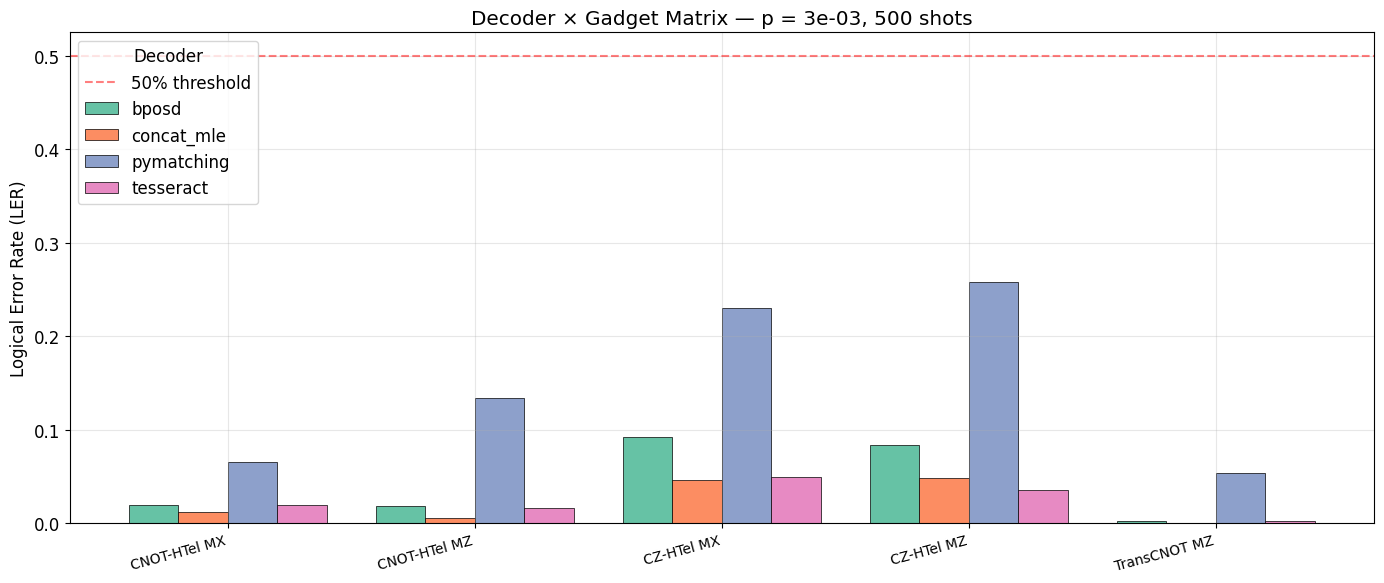

In [20]:
# ── Phase 2: grouped bar chart ───────────────────────────────────────

gadget_labels = list(pivot.columns)
n_gadgets = len(gadget_labels)
n_decoders = len(pivot.index)

x = np.arange(n_gadgets)
width = 0.8 / n_decoders
cmap = plt.cm.Set2

fig, ax = plt.subplots(figsize=(14, 6))
for i, dec in enumerate(pivot.index):
    vals = pivot.loc[dec].values.astype(float)
    offset = (i - n_decoders / 2 + 0.5) * width
    ax.bar(x + offset, vals, width, label=dec, color=cmap(i),
           edgecolor='k', linewidth=0.5)

ax.set_xticks(x)
ax.set_xticklabels(gadget_labels, fontsize=10, rotation=15, ha='right')
ax.set_ylabel('Logical Error Rate (LER)')
ax.set_title(f'Decoder × Gadget Matrix — p = {MATRIX_P:.0e}, {MATRIX_SHOTS} shots')
ax.axhline(0.50, color='red', linestyle='--', alpha=0.5, label='50% threshold')
ax.legend(title='Decoder', loc='upper left')
ax.set_ylim(bottom=0)
plt.tight_layout()
plt.show()

---
## Phase 3: Noise Scaling (α Estimation)

For a distance-$d$ code, the logical error rate scales as:

$$\text{LER}(p) \approx C \cdot p^\alpha \quad \text{with} \quad \alpha \approx \frac{d+1}{2}$$

We estimate $\alpha$ from two noise rates:

$$\alpha = \frac{\log(\text{LER}_{\text{hi}} / \text{LER}_{\text{lo}})}{\log(p_{\text{hi}} / p_{\text{lo}})}$$

| Distance | Expected $\alpha$ |
|----------|-------------------|
| $d = 3$  | $2.0$             |
| $d = 5$  | $3.0$             |
| $d = 7$  | $4.0$             |

In [11]:
# ── Phase 3: Alpha estimation ────────────────────────────────────────

def _estimate_alpha(code, gadget, num_blocks, p_lo, p_hi, shots):
    """Measure LER at two noise rates, compute scaling exponent."""
    r_lo = _measure_ler(code, gadget, num_blocks, p_lo, shots)
    r_hi = _measure_ler(code, gadget, num_blocks, p_hi, shots)
    if r_lo.logical_error_rate > 0 and r_hi.logical_error_rate > 0:
        alpha = (np.log(r_hi.logical_error_rate / r_lo.logical_error_rate)
                 / np.log(p_hi / p_lo))
    else:
        alpha = float('nan')
    return alpha, r_lo, r_hi


# d=5 is very well-protected at p=2e-3, so use higher noise rates
alpha_combos = [
    # (label, code, gadget, num_blocks, d, p_lo, p_hi)
    ('d=3 RotSurf CNOT-HTel MZ', RotatedSurfaceCode(3),
     CNOTHTeleportGadget(num_ec_rounds=3), 1, 3, 2e-3, 5e-3),
    ('d=3 RotSurf CNOT-HTel MX', RotatedSurfaceCode(3),
     CNOTHTeleportGadget(num_ec_rounds=3, input_state='+'), 1, 3, 2e-3, 5e-3),
    ('d=5 RotSurf CNOT-HTel MZ', RotatedSurfaceCode(5),
     CNOTHTeleportGadget(num_ec_rounds=5), 1, 5, 3e-3, 8e-3),
]

alpha_rows = []
print(f'Alpha estimation:  {ALPHA_SHOTS} shots per point\n')

for label, code, gadget, nb, d, p_lo, p_hi in alpha_combos:
    print(f'  {label:35s}  p=[{p_lo:.0e}, {p_hi:.0e}]', end='', flush=True)
    alpha, r_lo, r_hi = _estimate_alpha(code, gadget, nb,
                                        p_lo, p_hi, ALPHA_SHOTS)
    expected = (d + 1) / 2
    delta = abs(alpha - expected) if not np.isnan(alpha) else float('inf')
    status = '✓' if delta <= ALPHA_TOL else '✗'
    print(f'  α = {alpha:.2f}  (expected {expected:.1f})  {status}'
          f'  [{r_lo.logical_error_rate:.3e} → {r_hi.logical_error_rate:.3e}]')
    alpha_rows.append(dict(
        Label=label, d=d,
        alpha_measured=alpha, alpha_expected=expected,
        delta=delta, status=status,
        LER_lo=r_lo.logical_error_rate, LER_hi=r_hi.logical_error_rate,
        p_lo=p_lo, p_hi=p_hi,
        backend=r_lo.decoder_backend,
    ))

# Display table
try:
    import pandas as pd
    df_alpha = pd.DataFrame(alpha_rows)
    display(df_alpha[['Label', 'd', 'p_lo', 'p_hi', 'alpha_measured', 'alpha_expected',
                      'delta', 'status', 'LER_lo', 'LER_hi', 'backend']].style.hide(axis='index'))
except ImportError:
    for r in alpha_rows:
        print(f"  {r['Label']:35s}  alpha={r['alpha_measured']:.2f}  exp={r['alpha_expected']:.1f}  {r['status']}")

Alpha estimation:  2000 shots per point

  d=3 RotSurf CNOT-HTel MZ             p=[2e-03, 5e-03]  α = 1.87  (expected 2.0)  ✓  [6.500e-03 → 3.600e-02]
  d=3 RotSurf CNOT-HTel MX             p=[2e-03, 5e-03]  α = 1.97  (expected 2.0)  ✓  [5.500e-03 → 3.350e-02]
  d=5 RotSurf CNOT-HTel MZ             p=[3e-03, 8e-03]  α = 3.15  (expected 3.0)  ✓  [3.500e-03 → 7.700e-02]


Label,d,p_lo,p_hi,alpha_measured,alpha_expected,delta,status,LER_lo,LER_hi,backend
d=3 RotSurf CNOT-HTel MZ,3,0.002000,0.005000,1.868094,2.000000,0.131906,✓,0.006500,0.036000,tesseract
d=3 RotSurf CNOT-HTel MX,3,0.002000,0.005000,1.971860,2.000000,0.028140,✓,0.005500,0.033500,tesseract
d=5 RotSurf CNOT-HTel MZ,5,0.003000,0.008000,3.151458,3.000000,0.151458,✓,0.003500,0.077000,tesseract


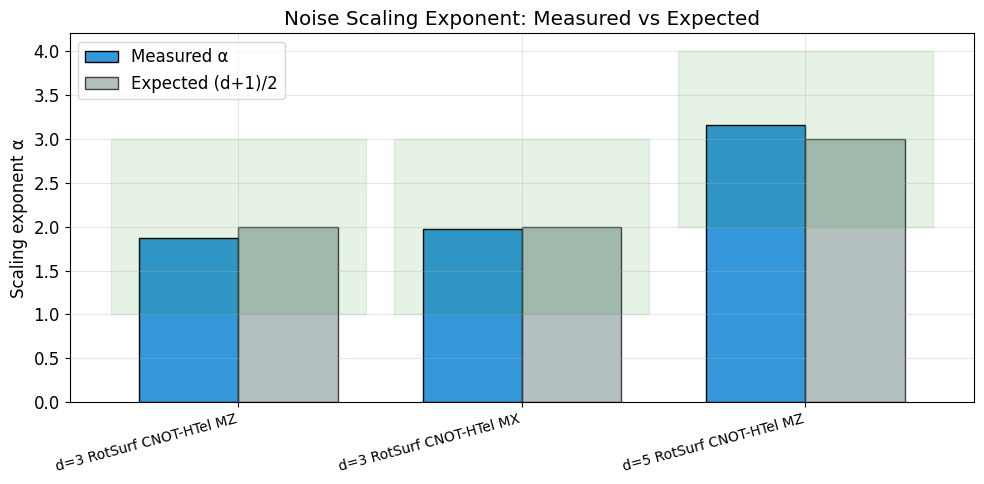

In [12]:
# ── Phase 3 bar chart: measured vs expected alpha ─────────────────────

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(alpha_rows))
width = 0.35
measured = [r['alpha_measured'] for r in alpha_rows]
expected = [r['alpha_expected'] for r in alpha_rows]
labels_a = [r['Label'] for r in alpha_rows]

bars1 = ax.bar(x - width/2, measured, width, label='Measured \u03b1',
               color='#3498db', edgecolor='k')
bars2 = ax.bar(x + width/2, expected, width, label='Expected (d+1)/2',
               color='#95a5a6', edgecolor='k', alpha=0.7)

# Tolerance band
for i, exp_a in enumerate(expected):
    ax.fill_between([i - 0.45, i + 0.45],
                    exp_a - ALPHA_TOL, exp_a + ALPHA_TOL,
                    alpha=0.1, color='green')

ax.set_xticks(x)
ax.set_xticklabels(labels_a, rotation=15, ha='right', fontsize=10)
ax.set_ylabel('Scaling exponent \u03b1')
ax.set_title('Noise Scaling Exponent: Measured vs Expected')
ax.legend()
plt.tight_layout()
plt.show()

---
## Phase 4: Multi-Point LER vs $p$ Scaling Plot

Sweep $p$ across several values and plot LER on a log-log scale.  
The slope on a log-log plot equals $\alpha$, so $d=5$ should be steeper than $d=3$.

**Note:** This takes a few minutes. Adjust `PLOT_P_VALUES` and `PLOT_SHOTS` above to speed it up.

  Sweeping d=3 CNOT-HTel MZ:  p=1e-03→2.000e-03  p=2e-03→8.000e-03  p=3e-03→2.200e-02  p=5e-03→4.000e-02  p=8e-03→9.000e-02
  Sweeping d=3 CNOT-HTel MX:  p=1e-03→0.000e+00  p=2e-03→0.000e+00  p=3e-03→1.400e-02  p=5e-03→3.400e-02  p=8e-03→7.400e-02
  Sweeping d=5 CNOT-HTel MZ:  p=1e-03→0.000e+00  p=2e-03→0.000e+00  p=3e-03→0.000e+00  p=5e-03→1.800e-02  p=8e-03→6.400e-02


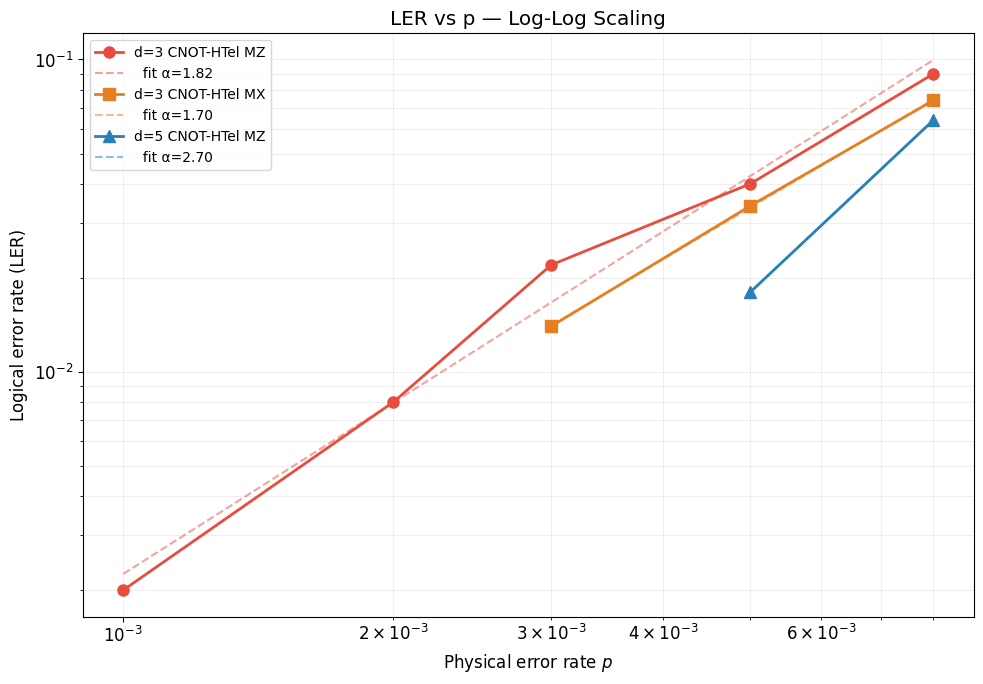

In [13]:
# ── Phase 4: Multi-point scaling curve ───────────────────────────────

scaling_configs = [
    ('d=3 CNOT-HTel MZ', RotatedSurfaceCode(3),
     CNOTHTeleportGadget(num_ec_rounds=3), 1, '#e74c3c', 'o'),
    ('d=3 CNOT-HTel MX', RotatedSurfaceCode(3),
     CNOTHTeleportGadget(num_ec_rounds=3, input_state='+'), 1, '#e67e22', 's'),
    ('d=5 CNOT-HTel MZ', RotatedSurfaceCode(5),
     CNOTHTeleportGadget(num_ec_rounds=5), 1, '#2980b9', '^'),
]

fig, ax = plt.subplots(figsize=(10, 7))

for label, code, gadget, nb, color, marker in scaling_configs:
    ps = []
    lers = []
    print(f'  Sweeping {label}:', end='', flush=True)
    for p in PLOT_P_VALUES:
        r = _measure_ler(code, gadget, nb, p, PLOT_SHOTS)
        ps.append(p)
        lers.append(r.logical_error_rate)
        print(f'  p={p:.0e}\u2192{r.logical_error_rate:.3e}', end='', flush=True)
    print()

    # Filter out LER=0 for log-log
    ps_nz  = [p for p, l in zip(ps, lers) if l > 0]
    lers_nz = [l for l in lers if l > 0]

    if len(ps_nz) >= 2:
        ax.loglog(ps_nz, lers_nz, marker=marker, color=color,
                  label=label, linewidth=2, markersize=8)
        # Fit line
        log_p = np.log(ps_nz)
        log_l = np.log(lers_nz)
        coeffs = np.polyfit(log_p, log_l, 1)
        fit_alpha = coeffs[0]
        ax.loglog(ps_nz,
                  np.exp(np.polyval(coeffs, np.log(ps_nz))),
                  '--', color=color, alpha=0.5,
                  label=f'  fit \u03b1={fit_alpha:.2f}')
    elif len(ps_nz) == 1:
        ax.loglog(ps_nz, lers_nz, marker=marker, color=color,
                  label=f'{label} (1 pt)', markersize=8)

ax.set_xlabel('Physical error rate $p$')
ax.set_ylabel('Logical error rate (LER)')
ax.set_title('LER vs p \u2014 Log-Log Scaling')
ax.legend(fontsize=10, loc='upper left')
ax.grid(True, which='both', alpha=0.2)
plt.tight_layout()
plt.show()

---
## Summary

In [21]:
# ── Summary ──────────────────────────────────────────────────────────

print('=' * 60)
print('  SUMMARY')
print('=' * 60)

# Phase 1
n_det_pass = sum(1 for r in det_rows if 'PASS' in r['Status'])
n_det_fail = sum(1 for r in det_rows if 'FAIL' in r['Status'] or 'flips' in r['Status'])
n_det_skip = sum(1 for r in det_rows if 'SKIP' in r['Status'])
print(f'\n  Phase 1 (determinism):  {n_det_pass} passed, {n_det_fail} failed, {n_det_skip} skipped')

# Phase 2 (now uses matrix_rows dicts)
_valid = [r for r in matrix_rows if isinstance(r['LER'], float) and not np.isnan(r['LER'])]
n_mat_ok   = sum(1 for r in _valid if 0 < r['LER'] < 0.50)
n_mat_zero = sum(1 for r in _valid if r['LER'] == 0)
n_mat_high = sum(1 for r in _valid if r['LER'] >= 0.50)
n_mat_err  = sum(1 for r in matrix_rows if not isinstance(r['LER'], float) or np.isnan(r['LER']))
print(f'  Phase 2 (decoder×gadget): {n_mat_ok} good, {n_mat_zero} zero-LER, '
      f'{n_mat_high} too high, {n_mat_err} errors')

# Phase 3
n_alpha_ok = sum(1 for r in alpha_rows if r['delta'] <= ALPHA_TOL)
n_alpha_bad = sum(1 for r in alpha_rows if r['delta'] > ALPHA_TOL)
print(f'  Phase 3 (scaling):     {n_alpha_ok} within tolerance, {n_alpha_bad} outside')
for r in alpha_rows:
    print(f"    {r['Label']:35s}  α = {r['alpha_measured']:.2f}  (exp {r['alpha_expected']:.1f})")

print('\n' + '=' * 60)
all_ok = (n_det_fail == 0 and n_mat_high == 0 and n_alpha_bad == 0)
if all_ok:
    print('  ALL CHECKS PASSED ✓')
else:
    print('  SOME CHECKS FAILED ✗')
print('=' * 60)

  SUMMARY

  Phase 1 (determinism):  12 passed, 0 failed, 8 skipped
  Phase 2 (decoder×gadget): 19 good, 1 zero-LER, 0 too high, 0 errors
  Phase 3 (scaling):     3 within tolerance, 0 outside
    d=3 RotSurf CNOT-HTel MZ             α = 1.87  (exp 2.0)
    d=3 RotSurf CNOT-HTel MX             α = 1.97  (exp 2.0)
    d=5 RotSurf CNOT-HTel MZ             α = 3.15  (exp 3.0)

  ALL CHECKS PASSED ✓
